<a href="https://colab.research.google.com/github/AAhmadS/NLP_HW4/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Natural Language Processing-Homework4**

####**Students' names** :
>Amirahmad Shafiee<br/>
>Ali Shafiee<br/>
>Neda Fallah<br/>
####**Student number** : 99104027<br/>**Chosen task** : classification In this notebook we aim to do common but rather essential preprocess actions on some text chosen from the persian literature world. After doing so, an NLP task would be operated on the processed text.

In [1]:
!pip install -qU transformers
!pip install -qU torchtext
!pip install -qU fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3946, done.
remote: Counting objects: 100% (974/974), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 3946 (delta 872), reused 831 (delta 820), pack-reused 2972
Receiving objects: 100% (3946/3946), 8.25 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (2510/2510), done.


In [3]:
import fasttext.util

In [4]:
# !sudo pip install fastText/.
# !cd fastText
# fasttext.util.download_model('fa', if_exists='ignore')
# ft = fasttext.load_model('cc.fa.300.bin')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/nlp_hw4

/content/drive/MyDrive/nlp_hw4


##Essential packages

In [7]:
import pandas as pd
import numpy as np
from numpy import pad
import json
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
from collections import Counter
from __future__ import unicode_literals, print_function, division
import random
from tqdm import tqdm
from sklearn.utils import resample
from joblib import Parallel, delayed
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
import sklearn.svm as svm
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score as acs
import plotly.express as px
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils.fixes import loguniform
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
import seaborn as sns
import fasttext.util

import itertools
import torch
from torch import nn
import torchtext
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F
from torch import optim

import nltk, re
from nltk import word_tokenize, sent_tokenize, WhitespaceTokenizer, FreqDist, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist


from transformers import pipeline, AutoTokenizer


import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os

import copy
import collections
import torch

##Load data and analysis


In [ ]:
# with open('food.jsonl', 'r') as json_file:
#     json_list = list(json_file)

# data_food = pd.DataFrame([])
# for json_str in json_list:
#     result = json.loads(json_str)
#     data_food = data_food.append(result,ignore_index=True)

# for i in range(data.shape[0]):
#   data_food["sentiment"][i] = int(data["sentiment"][i])+2

In [14]:
data = pd.read_csv('Cleaned_sentipers.csv')
data.drop(columns ={"Unnamed: 0","index","sid","file"},inplace=True)

In [15]:
data.isna().value_counts()

text   polarity  Cleaned_sentipers
False  False     False                15683
dtype: int64

In [17]:
data.polarity.value_counts()

 0    5938
 1    5019
 2    2940
-1    1574
-2     212
Name: polarity, dtype: int64

In [18]:
for i in range(data.shape[0]):
  data["polarity"][i] = int(data["polarity"][i])+2

<ipython-input-18-2996538be869>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["polarity"][i] = int(data["polarity"][i])+2


In [24]:
data.sample(10)

,text,polarity,Cleaned_sentipers,words_count
9584,کيفيت صفحه نسبت به قيمت خوبه .,3,کیفیت صفحه نسبت به قیمت خوبه,6
5742,در تست‌هایی که انجام دادیم به نظرمان نمایش متو...,1,در تست‌هایی که انجام دادیم به نظرمان نمایش متو...,13
13600,• نرم افزارهمان‌طور که در ابتدا گفتیم، گوگل ه...,2,• نرم افزارهمان‌طور که در ابتدا گفتیم گوگل هر ...,35
12568,دست کم بر روی عکس باندهای تاریک و روشن دیده نم...,2,دست کم بر روی عکس باندهای تاریک و روشن دیده نم...,12
12925,حتي من به دوستاي دانشجو که لب تاپ ندارند توصيه...,3,حتی من به دوستای دانشجو که لب تاپ ندارند توصیه...,22
13584,• طراحی و ساختاز لحاظ طراحی، Nexus 4 شباهت زی...,2,• طراحی و ساختاز لحاظ طراحی nexus 4 شباهت زیاد...,28
14574,در يک کلام ، فوق‌العادست.,3,در یک کلام فوق‌العادست,4
6648,تا به امروز هر چي از ديجي کالا خريدم با کيفيت ...,3,تا به امروز هر چی از دیجی کالا خریدم با کیفیت ...,15
6633,من حدود هفت ماهي هست که اين هاردو از ديجي کالا...,3,من حدود هفت ماهی هست که این هاردو از دیجی کالا...,23
14172,بدون لگ و تيک.,3,بدون لگ و تیک,4


In [20]:
data["words_count"] = [len(x.split()) for x in data["Cleaned_sentipers"]]

##Essential plots

In [27]:
class distributions:

  def minmax(data, col_end = 'words_count', col_beg = 'Cleaned_sentipers'):
    data[col_end] = data[col_beg].apply(lambda t: len(t.split()))

    summary = data[col_end].min(), data[col_end].max(), data[col_end].mean(), np.std(data[col_end])
    print(f" max: {summary[1]} \n min :{summary[0]}\n mean : {summary[2]}\n std : {summary[3]}")

  def word_freq(data, col_end = "words_count"):

      fig = go.Figure()

      fig.add_trace(go.Histogram(
          x=data[col_end]
      ))

      fig.update_layout(
          title_text='Distribution of word counts within data',
          xaxis_title_text='Word Count',
          yaxis_title_text='Frequency',
          bargap=0.2,
          bargroupgap=0.2)

      fig.show()

  def data_gl_than(data, less_than=50.0, greater_than=5.0, col='words_count'):
      data_length = data[col].values

      data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

      data_glt_rate = (data_glt / len(data_length)) * 100

      print(f'sentences with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

  def full_df_run(data, col_begin = 'words_count', minmax = True, freq = True, gl = True):
    if minmax :
      distributions.minmax(data)
    if freq:
      distributions.word_freq(data,col_end=col_begin)
    if gl:
      distributions.data_gl_than(data,col=col_begin)

  def word_and_freq(data, col = "tokenized"):
    tokenized_sent = data[col].values
    total_len = 0
    for i in range(len(tokenized_sent)):
      total_len += len(tokenized_sent[i])

    mp_freqdist = FreqDist(itertools.chain(*tokenized_sent))
    top20words=mp_freqdist.most_common(20)
    print ('%-16s' % 'word', '%-16s' % 'Frequency','%-16s' %  '% of the total')
    for topword in top20words:
        percent=(topword[1]/total_len)*100
        print ('%-16s' % topword[0], '%-16s' % topword[1],'%-16s' %  percent)

  def author_count(data, col_auth):
    fig = go.Figure()

    groupby_rate = data.groupby(col_auth)[col_auth].count()

    fig.add_trace(go.Bar(
        x=list(sorted(groupby_rate.index)),
        y=groupby_rate.tolist(),
        text=groupby_rate.tolist(),
        textposition='auto'
    ))

    fig.update_layout(
        title_text='Distribution of sentiments within sentences',
        xaxis_title_text='sentiment',
        yaxis_title_text='Frequency',
        bargap=0.2,
        bargroupgap=0.2)

    fig.show()

In [28]:
distributions.full_df_run(data)

 max: 338 
 min :1
 mean : 21.287381240834023
 std : 18.1482516158326


sentences with word length of greater than 5.0 and less than 50.0 includes 86.55% of the whole!


##Document classification

###SVM linear kernel

####Tf-Idf

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
corpus = [text for text in data["Cleaned_sentipers"]]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X)

  (0, 12120)	0.24912174301954468
  (0, 9303)	0.2611503254529635
  (0, 6725)	0.12309791900379546
  (0, 1411)	0.3055410591788662
  (0, 12060)	0.23535037135827547
  (0, 8725)	0.3308027388777241
  (0, 11373)	0.33968246056149715
  (0, 3033)	0.0926333373649946
  (0, 6699)	0.2647348357991808
  (0, 11371)	0.276615572922344
  (0, 6201)	0.33414805524663116
  (0, 8518)	0.2839804196229064
  (0, 3877)	0.365437490671731
  (1, 8810)	0.3282800055784347
  (1, 7319)	0.26489877533750567
  (1, 12485)	0.19420220274416544
  (1, 1595)	0.4402910943363797
  (1, 1168)	0.4402910943363797
  (1, 6802)	0.2662389647195084
  (1, 11829)	0.33913500164701366
  (1, 11647)	0.24063439502228265
  (1, 11375)	0.3779790455466683
  (1, 3033)	0.09982524275165751
  (2, 6193)	0.17462266032449633
  (2, 6053)	0.14911770386373085
  :	:
  (15682, 5570)	0.17874753429329693
  (15682, 5001)	0.31116322992126794
  (15682, 8708)	0.308311209204561
  (15682, 4660)	0.18054301750622265
  (15682, 3315)	0.20573994582020372
  (15682, 5841)	0.18345

In [32]:
##related to scaling and splitting

y = data['polarity']
x = X
# x=MinMaxScaler().fit_transform(x)
x_train , x_test , y_train , y_test = tts(x,y,test_size = 0.1 , random_state = 42)

In [33]:
parameters = dict(kernel=['linear'],C = [5e-3,1e-2,5e-2,1e-1,5e-1,1])

####Preprocess data<br/>implement the cross validation function

####Train and evaluation section

In [36]:
random_model = svm.SVC(max_iter=1000,probability=True,verbose=False)
Gmodel = GridSearchCV(estimator=random_model,param_grid=parameters,n_jobs=-1,cv=10,scoring='accuracy',refit=True)

In [37]:
Gmodel.fit(x_train,y_train)
model = Gmodel.best_estimator_

KeyboardInterrupt: ignored

In [38]:
print(f'score of model with score set to accuracy :{Gmodel.best_score_}\nparameters of model with score set to accuracy:{Gmodel.best_params_}\n-------')

AttributeError: ignored

In [ ]:
# def roc_curve(model,title,score,x,y):
#   y_score = model.predict_proba(x)[:, 1]
#   fpr, tpr, thresholds = metrics.roc_curve(y, y_score)

#   fig = px.area(
#       x=fpr, y=tpr,
#       title=f'{title}\'s ROC Curve (AUC={auc(fpr, tpr):.4f})  -- score:{score}',
#       labels=dict(x='False Positive Rate', y='True Positive Rate'),
#       width=700, height=500
#   )
#   fig.add_shape(
#       type='line', line=dict(dash='dash'),
#       x0=0, x1=1, y0=0, y1=1
#   )

#   fig.update_yaxes(scaleanchor="x", scaleratio=1)
#   fig.update_xaxes(constrain='domain')
#   fig.show()

# roc_curve(modelAcc,"Model_acc","accuracy",x_train,y_train)
# roc_curve(modelF1,"Model_f1","f1",x_train,y_train)
# roc_curve(modelRac,"Model_rac","roc_auc",x_train,y_)

# plt.legend()
# plt.show()

In [ ]:
# def prec_recall(model,title,score,x,y):

#   y_score = model.predict_proba(x)[:, 1]
#   precision, recall, thresholds = precision_recall_curve(y, y_score)

#   fig = px.area(
#       x=recall, y=precision,
#       title=f'{title}\'s Precision-Recall Curve (AUC={auc(precision, recall):.4f}) -- score : {score}',
#       labels=dict(x='Recall', y='Precision'),
#       width=700, height=500
#   )
#   fig.add_shape(
#       type='line', line=dict(dash='dash'),
#       x0=0, x1=1, y0=1, y1=0
#   )
#   fig.update_yaxes(scaleanchor="x", scaleratio=1)
#   fig.update_xaxes(constrain='domain')

#   fig.show()


# prec_recall(modelAcc,"Model_acc","accuracy",x_train,y_train)
# prec_recall(modelF1,"Model_f1","f1",x_train,y_train)
# prec_recall(modelRac,"Model_rac","roc_auc",x_train,y_train)

# plt.legend()
# plt.show()

In [ ]:
def learning_curve(model,x,y,fold,title):
  train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=x, y=y,cv=fold,)
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
  plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
  plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
  plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
  plt.title(f'Learning Curve for {title}')
  plt.xlabel('Training Data Size')
  plt.ylabel('Model accuracy')
  plt.grid()
  plt.legend(loc='lower right')
  plt.show()


learning_curve(model,x_train,y_train,10,"model_acc")

NameError: ignored

####Test

In [ ]:
predicted_classes = model.predict(x_test)
metrics.confusion_matrix(y_test,predicted_classes)

In [ ]:
print(classification_report(y_test, predicted_classes))

###Transformer-based model

####Preprocess

In [39]:
##set word_tokenizer, sent tokenizer, normalizer, lemmatizer and other tooks to suitable and favoured persian ones
!pip install -q hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 46.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [40]:
import hazm
word_tokenizer = hazm.WordTokenizer()
normalizer = hazm.Normalizer()
sent_tokenizer = hazm.SentenceTokenizer()
lemmatizer = hazm.Lemmatizer()

#####Subsection 1: tokenizing

In [41]:
tokenized_sents = [word_tokenizer.tokenize(sent) for sent in data["Cleaned_sentipers"]]
data["tokenized"] = tokenized_sents
data.sample(5)

,text,polarity,Cleaned_sentipers,words_count,tokenized
2598,وب کم این نوت‌بوک‌ها رزولوشن VGA را ارایه می‌د...,3,وب کم این نوت‌بوک‌ها رزولوشن vga را ارایه می‌د...,23,"[وب, کم, این, نوت‌بوک‌ها, رزولوشن, vga, را, ار..."
4545,یکی از بهترین تغییراتی که سونی روی این تبلت ان...,4,یکی از بهترین تغییراتی که سونی روی این تبلت ان...,30,"[یکی, از, بهترین, تغییراتی, که, سونی, روی, این..."
9189,نرم افزاراز لحاظ نرم افزاری، HTC One X Plus ب...,2,نرم افزاراز لحاظ نرم افزاری htc one x plus به ...,21,"[نرم, افزاراز, لحاظ, نرم, افزاری, htc, one, x,..."
10981,فوکوس خودکار، ژئوتگینگ و همچنین حالت‌های مختل...,2,فوکوس خودکار ژیوتگینگ و همچنین حالت‌های مختلف ...,20,"[فوکوس, خودکار, ژیوتگینگ, و, همچنین, حالت‌های,..."
14162,ولي قابل تحمل .,3,ولی قابل تحمل,3,"[ولی, قابل, تحمل]"


In [42]:
distributions.word_and_freq(data,"tokenized")

word             Frequency        % of the total  
و                11550            3.436170529259513
به               8497             2.5278909945556776
که               8334             2.479397852021539
این              7744             2.303870526284473
از               7182             2.1366733109213696
در               7110             2.115253027102609
با               5552             1.651741885579984
گوشی             3777             1.1236723886591498
را               3312             0.9853330556629875
است              2965             0.8820991878142386
دوربین           2805             0.8344985571058816
هم               2782             0.8276559664415553
های              2222             0.6610537589623062
آن               2089             0.6214857346859847
یک               2067             0.6149406479635855
برای             2052             0.6104780888346771
من               2004             0.5961978996221701
می               1986             0.5908428286674798


**In the next subsection** we will check again after normalising our data, actions like:
>omitting stopwords<br/>
>punctuations removal

#####Subsection 2: normalising

In [173]:
stop_words = ["برای","در","را","رو","اند","بود","است","هم","آن","بوده","این","پیش","بعد","همراه","به","ز","تا","اگر","پی","پس","بی","با","یا","که","از","و"]

In [174]:
import string

def clean_text(text):
    #removing roman numbers
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    re.sub(pattern, '&', text)
    #removing numbers
    text_nonum = re.sub(r'\d+', '', text)
    #getting rid of punctuations
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation])
    #getting rid of white spaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()

    return text_no_doublespace

def normalize_sentence(tokenized_sents, minimum_length=1, stopword_removal=True, number_removal = True):

    normalized_sents = tokenized_sents
    if stopword_removal:
        normalized_sents=[[word for word in sentence if (word not in stop_words)] for sentence in normalized_sents ]

    if minimum_length>1:
        normalized_sents= [[word for word in sentence if len(word)>minimum_length] for sentence in normalized_sents ]

    return normalized_sents

In [175]:
clean_token = [word_tokenizer.tokenize(clean_text(txt)) for txt in data["Cleaned_sentipers"]]
data["clean_token"] = clean_token
normalized_sents = normalize_sentence(clean_token,)
data["normalized_sents"] = normalized_sents

In [176]:
data.sample(5)

,text,polarity,Cleaned_sentipers,words_count,tokenized,clean_token,normalized_sents,words_norm_count,label,lemmatized
13418,مود AV درست بر عکس TV است و اختیار تنظیم سرعت ...,2,مود av درست بر عکس tv است و اختیار تنظیم سرعت ...,22,"[مود, av, درست, بر, عکس, tv, است, و, اختیار, ت...","[مود, av, درست, بر, عکس, tv, است, و, اختیار, ت...","[مود, av, درست, بر, عکس, tv, اختیار, تنظیم, سر...",17,Neutral,"[مود, av, درست, بر, عکس, tv, اختیار, تنظیم, سر..."
15657,این امکان آخری بسیار کارآمد و خوب می باشد و بر...,4,این امکان آخری بسیار کارآمد و خوب می باشد و بر...,20,"[این, امکان, آخری, بسیار, کارآمد, و, خوب, می, ...","[این, امکان, آخری, بسیار, کارآمد, و, خوب, می, ...","[امکان, آخری, بسیار, کارآمد, خوب, می, باشد, دی...",15,Delighted,"[امکان, آخر, بسیار, کارآمد, خوب, می, بود#باش, ..."
6796,در عوض بي نهايت زيباست کيفيت دوربينش هم خوبه,4,در عوض بی نهایت زیباست کیفیت دوربینش هم خوبه,9,"[در, عوض, بی, نهایت, زیباست, کیفیت, دوربینش, ه...","[در, عوض, بی, نهایت, زیباست, کیفیت, دوربینش, ه...","[عوض, نهایت, زیباست, کیفیت, دوربینش, خوبه]",6,Delighted,"[عوض, نهایت, زیباست, کیفیت, دوربین, خوبه]"
7528,در ضمن، یک دوربین 2 مگاپیکسلی نیز در قسمت جلو...,3,در ضمن یک دوربین 2 مگاپیکسلی نیز در قسمت جلویی...,29,"[در, ضمن, یک, دوربین, 2, مگاپیکسلی, نیز, در, ق...","[در, ضمن, یک, دوربین, مگاپیکسلی, نیز, در, قسمت...","[ضمن, یک, دوربین, مگاپیکسلی, نیز, قسمت, جلویی,...",22,Happy,"[ضمن, یک, دوربین, مگاپیکسلی, نیز, قسمت, جلو, گ..."
2438,واقعا حرف نداره، و اينو استقبال مردم در پيش خ...,3,واقعا حرف نداره و اینو استقبال مردم در پیش خری...,12,"[واقعا, حرف, نداره, و, اینو, استقبال, مردم, در...","[واقعا, حرف, نداره, و, اینو, استقبال, مردم, در...","[واقعا, حرف, نداره, اینو, استقبال, مردم, خرید,...",9,Happy,"[واقعا, حرف, نداره, اینو, استقبال, مردم, خرید,..."


In [177]:
distributions.word_and_freq(data,"normalized_sents")

word             Frequency        % of the total  
گوشی             3776             1.5277553002103899
دوربین           2808             1.136106166046286
های              2222             0.8990127852403301
یک               2068             0.8367049684414953
من               2004             0.8108108108108109
می               1986             0.8035280789771807
خیلی             1817             0.7351513189836543
بسیار            1630             0.6594918271564978
کیفیت            1563             0.6323838808868749
نیز              1477             0.5975886065706425
صفحه             1432             0.5793817769865675
بر               1374             0.5559151966337595
ولی              1360             0.5502508496520473
نظر              1299             0.525570480660301
روی              1186             0.47985110859362357
تبلت             1183             0.4786373199546852
دارد             1132             0.45800291309273344
استفاده          1085             0.438986891082

In [178]:
data["words_norm_count"] = [len(sen) for sen in data["normalized_sents"]]
distributions.data_gl_than(data,col = "words_norm_count")

sentences with word length of greater than 5.0 and less than 50.0 includes 84.44% of the whole!


#####Subsection 3: Frequency analysis

In [50]:
distributions.full_df_run(data, minmax=False,col_begin="words_norm_count")
distributions.author_count(data, "polarity")

sentences with word length of greater than 5.0 and less than 50.0 includes 84.46% of the whole!


In [137]:
name_list = ["Furious","Angry","Neutral","Happy","Delighted"]
labels= [name_list[int(i)] for i in data['polarity']]
data["label"] = labels
for name in name_list:
  df = data[data["label"]==name]
  print(f"\nword frequency within {name}'s polarity is as follows:\n")
  distributions.word_and_freq(df,"normalized_sents")


word frequency within Furious's polarity is as follows:

word             Frequency        % of the total  
خیلی             65               1.5546519971298733
گوشی             52               1.2437215977038987
من               45               1.0762975364745277
کیفیت            38               0.9088734752451567
بسیار            36               0.8610380291796221
نیست             33               0.7892848600813203
می               33               0.7892848600813203
های              28               0.6696962449174839
دوربین           28               0.6696962449174839
برای             27               0.6457785218847166
ولی              26               0.6218607988519493
پایین            25               0.597943075819182
صفحه             25               0.597943075819182
داره             25               0.597943075819182
هست              24               0.5740253527864148
تبلت             24               0.5740253527864148
نظر              24               0.5740253527

#####Subsection 5: lemmatization

In [251]:
lem_sents = []
for nsent in data["normalized_sents"]:
  tokens = []
  for token in nsent:
    tokens.append(lemmatizer.lemmatize(token))
  lem_sents.append(tokens)
data["lemmatized"] = lem_sents
# data["lemmatized"] = data["normalized_sents"]

In [252]:
data.sample(5)

,text,polarity,Cleaned_sentipers,words_count,tokenized,clean_token,normalized_sents,words_norm_count,label,lemmatized
15177,اين گوشي براي انگشتان بزرگ مناسب است,3,این گوشی برای انگشتان بزرگ مناسب است,7,"[این, گوشی, برای, انگشتان, بزرگ, مناسب, است]","[این, گوشی, برای, انگشتان, بزرگ, مناسب, است]","[گوشی, انگشتان, بزرگ, مناسب]",4,Happy,"[گوشی, انگ, بزرگ, مناسب]"
14277,پلی استیشن‌2 یک سیستم کامپیوتری مختص سرگرمی اس...,3,پلی استیشن‌2 یک سیستم کامپیوتری مختص سرگرمی اس...,29,"[پلی, استیشن‌, 2, یک, سیستم, کامپیوتری, مختص, ...","[پلی, استیشن‌, یک, سیستم, کامپیوتری, مختص, سرگ...","[پلی, استیشن‌, یک, سیستم, کامپیوتری, مختص, سرگ...",20,Happy,"[پل, استیشن‌, یک, سیستم, کامپیوتری, مختص, سرگر..."
12754,درود اين محصول سامسونگ از جهات بسياري مطلوب و ...,0,درود این محصول سامسونگ از جهات بسیاری مطلوب و ...,66,"[درود, این, محصول, سامسونگ, از, جهات, بسیاری, ...","[درود, این, محصول, سامسونگ, از, جهات, بسیاری, ...","[درود, محصول, سامسونگ, جهات, بسیاری, مطلوب, قا...",45,Furious,"[درود, محصول, سامسونگ, جهات, بسیار, مطلوب, قاب..."
2456,اپل در واقع يک سر وگردن از شرکت هاي مقابل خود ...,2,اپل در واقع یک سر وگردن از شرکت های مقابل خود ...,13,"[اپل, در, واقع, یک, سر, وگردن, از, شرکت, های, ...","[اپل, در, واقع, یک, سر, وگردن, از, شرکت, های, ...","[اپل, واقع, یک, سر, وگردن, شرکت, های, مقابل, خ...",10,Neutral,"[اپل, واقع, یک, سر, وگردن, شرکت, های, مقابل, خ..."
1901,درسته که المينيوم دورش مقاومت کمتري داره ولي ب...,3,درسته که المینیوم دورش مقاومت کمتری داره ولی ب...,30,"[درسته, که, المینیوم, دورش, مقاومت, کمتری, دار...","[درسته, که, المینیوم, دورش, مقاومت, کمتری, دار...","[درسته, المینیوم, دورش, مقاومت, کمتری, داره, و...",21,Happy,"[درسته, المینیوم, دور, مقاومت, کمتری, داره, ول..."


In [253]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [254]:
train, test = tts(data, test_size=0.1, random_state=1, stratify=data['polarity'])
train, valid = tts(train, test_size=0.1, random_state=1, stratify=train['polarity'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['lemmatized'].values.tolist(), train['polarity'].values.tolist()
x_valid, y_valid = valid['lemmatized'].values.tolist(), valid['polarity'].values.tolist()
x_test, y_test = test['lemmatized'].values.tolist(), test['polarity'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(12702, 10)
(1412, 10)
(1569, 10)


#### Configuration

In [255]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [256]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

EPOCHS = 5
EEVERY_EPOCH = 397
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/sentiment_classification_bert/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [257]:
# create a key finder based on label 2 id and id to label
label2id = {label: i for i, label in enumerate(name_list)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'Furious': 0, 'Angry': 1, 'Neutral': 2, 'Happy': 3, 'Delighted': 4}
id2label: {0: 'Furious', 1: 'Angry', 2: 'Neutral', 3: 'Happy', 4: 'Delighted'}


In [258]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Furious",
    "1": "Angry",
    "2": "Neutral",
    "3": "Happy",
    "4": "Delighted"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Angry": 1,
    "Delighted": 4,
    "Furious": 0,
    "Happy": 3,
    "Neutral": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



#### Input Embeddings

In [259]:
idx = np.random.randint(0, len(train))
sample_rev = train.iloc[idx]['lemmatized']
sample_sent = train.iloc[idx]['polarity']

print(f'Sample: \n{" ".join(sample_rev)}\n{sample_sent}')

Sample: 
غیر dvd rom
2


In [260]:
tokens = train.iloc[idx]["lemmatized"]
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  sentence: {" ".join(sample_rev)}')
print(f'  Coded_tokens: {tokens}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  sentence: غیر dvd rom
  Coded_tokens: ['غیر', 'dvd', 'rom']
   Tokens: غیر dvd rom
Token IDs: [3268, 28253, 25283]


In [261]:
encoding = tokenizer.encode_plus(
    sample_rev,
    max_length=MAX_LEN,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3268, 28253, 25283,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

#### Dataset

In [262]:
class SentDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, sent, targets=None, label_list=None, max_len=MAX_LEN):
        self.sent = sent
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len


        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}

    def __len__(self):
        return len(self.sent)

    def __getitem__(self, item):
        sentence = str(self.sent[item])

        if self.has_target:
            target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        inputs = {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)

        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = SentDataset(
        sent=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len,
        label_list=label_list)

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [263]:
label_list = name_list
train_data_loader = create_data_loader(train['lemmatized'].to_numpy(), train['polarity'].to_numpy(dtype=int), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['lemmatized'].to_numpy(), valid['polarity'].to_numpy(dtype=int), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['lemmatized'].to_numpy(), test["polarity"].to_numpy(dtype=int), tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [264]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['sentence'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'])

dict_keys(['sentence', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
["['فقط', 'باید', 'بگم', 'عالیه', 'نقاشی', 'گرفته', 'کارا', 'مهندس', 'طراح']", "['برام', 'عجیبه', 'یه', 'جمله', '#هست', 'اشتباه', 'درمورد', 'اپل', 'جا', 'افتاده', 'اینه', 'اپل', 'تو', 'ایران', 'کارا', 'باید', 'نداره']", "['البته', 'نرم\\u200cافزار', 'امکانات', 'jvc', 'کار', 'کرد#کن', 'مشکل', 'برنخواهید', 'خورد#خور']", "['ناگفته', 'نمونه', 'اینکه', 'ساکن', 'تهران', 'نیستم', 'برام', 'هزینه', '#هست', 'پس', 'اعمال', 'میشه', 'همیشه', 'دیجی', 'کالا', 'خرید', 'میکنم', 'چند', 'دلیل', 'همه', 'مه', 'کالا', 'اصل', 'درجه', 'یک', 'تحویل', 'میده', 'بسته', 'بند', 'عالیه', 'ساعت', 'مهلت', 'تست', 'داره', 'اینکه', 'بیش', 'قلم', 'کالا', 'جمله', 'لب', 'تاب', 'هارد', 'دوربین']", "['پرینتر', 'شما', 'اجازه', '#هست', 'استفاده', 'کارت', 'حافظه', 'پرینت', 'مستقیم', 'روی', 'نمایش', 'عکس', 'ها', 'بر', 'روی', 'نمایشگر', 'رنگ', 'اینچ', 'می', 'داد#ده']", "['صفحه', '#هست', 'لمس', 'بزرگ', 'xr', 'رزولوشن', 'بالاست', 'کارا', 'خوبی', 'داش

In [265]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['sentence', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])


In [266]:
class ClassifierModel(nn.Module):

    def __init__(self, config,output_size):
        super(ClassifierModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(config.hidden_size,output_size)

    def forward(self, input_ids, attention_mask, token_type_ids):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)['pooler_output']

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [267]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

In [268]:
pt_model = ClassifierModel(config=config,output_size=5)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.ClassifierModel'>


In [269]:
for name,param in pt_model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

#### Training

In [270]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os

import copy
import collections
import torch

In [271]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)

    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model,
             data_loader,
             loss_fn,
             optimizer,
             scheduler,
             step=0,
             print_every_step=397,
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None,
             clip=0.0):

    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)

        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])
        statement += 'Train F1: {:.3f}...'.format(train_score['f1'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])
        statement += 'Valid F1: {:.3f}...'.format(eval_score['f1'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))

            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss

        return eval_loss_min


    return eval_cb

In [272]:
from torch import optim
from transformers import AdamW

optimizer = optim.AdamW(pt_model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
summed = sum([len(train['polarity'] == i) for i in range(5)])
weight = torch.tensor([len(train['polarity'] == i) for i in range(5)]).to(device) / summed
loss_fn = nn.CrossEntropyLoss(weight=weight)

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        step=step,
        print_every_step=EEVERY_EPOCH,
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader,
        clip=CLIP)

    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

    eval_y, eval_loss = eval_op(
        model=pt_model,
        data_loader=valid_data_loader,
        loss_fn=loss_fn)

    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_score['f1'])
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)
    history['val_f1'].append(eval_score['f1'])

Epochs... :   0%|          | 0/5 [00:00<?, ?it/s]

Training... :   0%|          | 0/397 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1/5...Step: 397...Train Loss: 1.037315...Train Acc: 0.561...Train F1: 0.550...Valid Loss: 0.823795...Valid Acc: 0.660...Valid F1: 0.656...
Validation loss decreased (inf --> 0.823795).  Saving model ...


Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Training... :   0%|          | 0/397 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 2/5...Step: 794...Train Loss: 0.777039...Train Acc: 0.696...Train F1: 0.692...Valid Loss: 0.774006...Valid Acc: 0.695...Valid F1: 0.693...
Validation loss decreased (0.823795 --> 0.774006).  Saving model ...


Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Training... :   0%|          | 0/397 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 3/5...Step: 1191...Train Loss: 0.614393...Train Acc: 0.763...Train F1: 0.760...Valid Loss: 0.761529...Valid Acc: 0.715...Valid F1: 0.715...
Validation loss decreased (0.774006 --> 0.761529).  Saving model ...


Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Training... :   0%|          | 0/397 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 4/5...Step: 1588...Train Loss: 0.493382...Train Acc: 0.817...Train F1: 0.814...Valid Loss: 0.773737...Valid Acc: 0.715...Valid F1: 0.714...


Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Training... :   0%|          | 0/397 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 5/5...Step: 1985...Train Loss: 0.408521...Train Acc: 0.853...Train F1: 0.851...Valid Loss: 0.814577...Valid Acc: 0.722...Valid F1: 0.722...


Evaluation... :   0%|          | 0/45 [00:00<?, ?it/s]

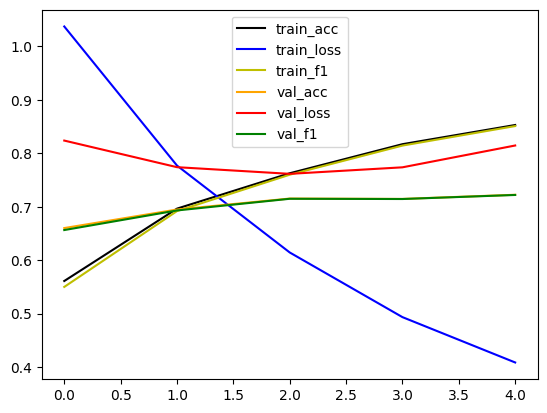

In [273]:
keyset = ['train_acc','train_loss','train_f1','val_acc','val_loss','val_f1']
colors = ['black','blue','y','orange','red','g']
for i in range(len(keyset)):
  x = history[keyset[i]]
  plt.plot(x,colors[i],label = keyset[i])

plt.legend()
plt.show()

#### Prediction

In [274]:
def predict(model, comments, tokenizer, max_len=MAX_LEN, batch_size=16):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)

    predictions = []
    prediction_probs = []


    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [275]:
model = ClassifierModel(config=config,output_size=5)
model = model.to(device)

model.load_state_dict(torch.load(OUTPUT_PATH))
model.eval()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ClassifierModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [276]:
test_sents = test['lemmatized'].to_numpy()
preds, probs = predict(model, test_sents, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/99 [00:00<?, ?it/s]

(1569,) (1569, 5)


In [277]:
print(f"predictions : {preds}\n with accuracy : {(preds == test.polarity.to_numpy(dtype=int)).mean()}")

predictions : [2 4 2 ... 2 3 1]
 with accuracy : 0.7049075844486934


In [278]:
preds_label = [id2label[t] for t in preds]
preds_label[0:5]

['Neutral', 'Delighted', 'Neutral', 'Happy', 'Happy']

####F1 Score and report

In [279]:
y_test, y_pred = test['polarity'].values.astype(int), preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print("--------------classification_report---------------")
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.7036014712265563
--------------classification_report---------------
              precision    recall  f1-score   support

     Furious       0.50      0.14      0.22        21
       Angry       0.54      0.62      0.58       158
     Neutral       0.79      0.73      0.76       594
       Happy       0.67      0.67      0.67       502
   Delighted       0.72      0.81      0.76       294

    accuracy                           0.70      1569
   macro avg       0.64      0.59      0.60      1569
weighted avg       0.71      0.70      0.70      1569



In [280]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[  3,  11,   3,   4,   0],
       [  3,  98,  37,  20,   0],
       [  0,  51, 432,  99,  12],
       [  0,  20,  66, 334,  82],
       [  0,   2,  10,  43, 239]])

##Token classification

###GRU and LSTM

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self,
        num_classes,
        batch_size=10,
        embedding_dim=100,
        hidden_dim=50,
        vocab_size=128):

        super(LSTMClassifier, self).__init__()

        initrange = 0.1

        self.num_labels = num_classes
        n = len(self.num_labels)
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.uniform_(-initrange, initrange)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)  # !

        print("# !")

        bi_grus = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        reverse_gru = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=False)

        self.lstm.weight_ih_l0_reverse = bi_grus.weight_ih_l0_reverse
        self.lstm.weight_hh_l0_reverse = bi_grus.weight_hh_l0_reverse
        self.lstm.bias_ih_l0_reverse = bi_grus.bias_ih_l0_reverse
        self.lstm.bias_hh_l0_reverse = bi_grus.bias_hh_l0_reverse

        bi_output, bi_hidden = bi_grus()
        reverse_output, reverse_hidden = reverse_gru()

        print("# !")

        # self.classifier = nn.Linear(hidden_dim, self.num_labels[0])
        self.classifier = nn.Linear(2 * hidden_dim, self.num_labels[0])  # !


    def repackage_hidden(h):
        """Wraps hidden states in new Tensors, to detach them from their history."""

        if isinstance(h, torch.Tensor):
            return h.detach()
        else:
            return tuple(repackage_hidden(v) for v in h)


    def forward(self, sentence, labels=None):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)  # lstm_out - 2 tensors, _ - hidden layer
        print(lstm_out[:,-1,:])
        tag_space = self.classifier(lstm_out[:,-1,:] + lstm_out[:,-1,:])  # !  # lstm_out[:,-1,:] - 1 tensor
        logits = F.log_softmax(tag_space, dim=1)
        loss = None
        if labels:
            loss = F.cross_entropy(logits.view(-1, self.num_labels[0]), labels[0].view(-1))
        return loss, logits

###Transformer-based model